In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import spektral
import tensorflow as tf

from scipy.sparse import csr_array, csr_matrix, load_npz

tf.keras.backend.set_floatx('float32')

2023-03-15 18:54:10.058357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 18:54:10.362034: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 18:54:12.379290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-15 18:54:12.379511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
class GraphDataset(spektral.data.Dataset):
    def __init__(self, path, **kwargs):
        self.data_path = path
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in range(int(len(os.listdir(self.data_path))/2)):
            graph = np.load(self.data_path + "graph_{}.npz".format(i))
            adjacency = load_npz(self.data_path + "adjacency_{}.npz".format(i))
            output.append(spektral.data.graph.Graph(x=graph['x'],
                                                    a=adjacency,
                                                    y=graph['y']))
        return output

In [3]:
train_ds = GraphDataset("dataset/train/")
test_ds = GraphDataset("dataset/test/")
val_ds = GraphDataset("dataset/validation/")

In [4]:
class GraphAttentionNetwork(tf.keras.models.Model):
    def __init__(self, nlayers=1, dim_features=10, dim_global_features=6, dropout=0.5):
        super().__init__()
        self.nlayers = nlayers
        self.dim_features = dim_features
        self.dim_global_features = dim_global_features
        self.dropout = dropout

        self.attention = []
        self.skip = []
        for i in range(self.nlayers):
            self.attention.append(spektral.layers.GATConv(channels=self.dim_features, attn_heads=1, dropout_rate=self.dropout))
            self.skip.append(tf.keras.layers.Dense(self.dim_features, activation="relu", use_bias=True))

        self.avgpool = spektral.layers.GlobalAvgPool()
        self.layernorm = tf.keras.layers.LayerNormalization(axis=-1)
        self.concat = tf.keras.layers.Concatenate(axis=-1)

        self.regression = [tf.keras.layers.Dense(128, activation="relu", use_bias=True)]
        self.regression.append(tf.keras.layers.Dense(128, activation="relu", use_bias=True))
        self.regression.append(tf.keras.layers.Dense(1, activation="sigmoid", use_bias=True)) 

        self.global_features = [tf.keras.layers.Dense(12, activation="relu", use_bias=True)]
        self.global_features.append(tf.keras.layers.Dense(12, activation="relu", use_bias=True))
        self.global_features.append(tf.keras.layers.Dense(6, activation="relu", use_bias=True))


    def call(self, inputs):
        x = inputs[0][:,1:,:]
        a = inputs[1][:,:-1,:-1]
        gf = inputs[0][:,0,:6]

        for (attention_layer, skip_layer) in zip(self.attention, self.skip):
            x = self.layernorm(x)
            x_attention = attention_layer([x,a])
            x_skip = skip_layer(x)
            x = x_skip + x_attention
        
        x = self.layernorm(x)
        x = self.avgpool(x)

        for layer in self.global_features:
            gf = layer(gf)
        
        x = self.concat([x, gf])
        
        for layer in self.regression:
            x = layer(x)
        return x

In [5]:
model = GraphAttentionNetwork(nlayers=1)
model.load_weights("./logs/graphattention/quest/1_layers_rightencoding/model_weights")

2023-03-15 18:55:20.047860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 18:55:20.047919: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 18:55:20.047949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (icme-gpu1): /proc/driver/nvidia/version does not exist
2023-03-15 18:55:20.048395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def predict_dataset(model, ds):
    predictions = []
    for i, graph in enumerate(ds):
        x = graph.x.reshape(1, graph.x.shape[0], graph.x.shape[1])
        a = graph.a.toarray()
        a = np.pad(a, ((0,1),(0,1)))
        a = a.reshape(1, a.shape[0], a.shape[1])
        predictions.append(float(model([x,a], training=False)))
        if i % 1000 == 0:
            print("Step", i)
    return predictions

In [7]:
train_predictions = predict_dataset(model, train_ds)
test_predictions = predict_dataset(model, test_ds)

train_y = [float(graph.y) for graph in train_ds]
test_y = [float(graph.y) for graph in test_ds]

kl = sum([-p*np.log(q/p) - (1-p)*np.log((1-q)/(1-p)) for p,q in zip(test_y, test_predictions)])/len(test_y)

Step 0
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Step 6000
Step 7000
Step 8000
Step 9000
Step 10000
Step 11000
Step 0
Step 1000


In [10]:
predictions_sandia = np.load("../data/mcb-7/ibmq_belem/Pauli_Stochastic/predictions/none_Shots/nn_predictions.npz")
sandia_kl = sum([-p*np.log(q/p) - (1-p)*np.log((1-q)/(1-p)) for p,q in zip(test_y, predictions_sandia["test"])])/len(test_y)

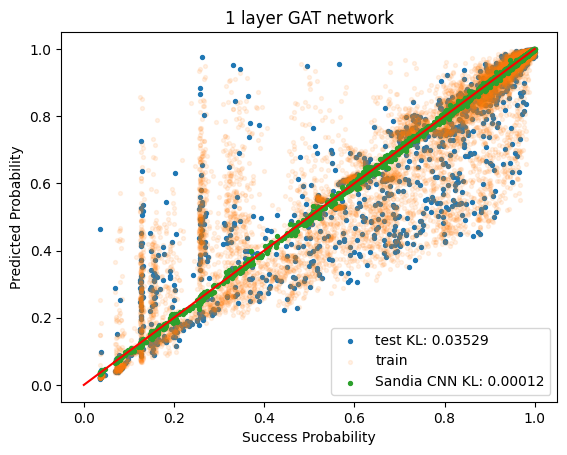

In [11]:
plt.figure()
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000), color='r')
plt.scatter(test_y, test_predictions, 8, label="test KL: {:.5f}".format(kl))
plt.scatter(train_y, train_predictions, 8, label="train", alpha=0.1)
plt.scatter(test_y, predictions_sandia["test"], 8, label="Sandia CNN KL: {:.5f}".format(sandia_kl))

plt.xlabel("Success Probability")
plt.ylabel("Predicted Probability")
plt.title("1 layer GAT network")
plt.legend()
plt.show()
